# <i class="fas fa-circle mandatory"></i> Pupil detection
<span class="badge badge-pill mandatory-bg">mandatory</span><span class="badge badge-pill badge-dark">notebook</span>

In this second assignment, you have to implement a method that detects the pupil in eye images. The ellipse is a suitable model for approximating the pupil shape as it is projected onto the two-dimensional image from three-dimensional space. The basic method for finding pupils will be provided for you, but you will be asked questions about the implementation. 

Additionally, you will implement the RANSAC method for making the pupil detection method more robust to outliers. Finally, you have to evaluate your implementations and reflect on the impact of using RANSAC as well as how much the pupil detection process is responsible for the final gaze error.

```{note}
The real notebook (the one in the materials repository or the one you can download from this page) contains a lot of extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.
```

```{note}
To evaluate the pupil detector you need to include a (working!) gaze model implementation from assignment 1. Just copy over your own implementation for the 2. degree polynomial.
```

## Hand-in
You have to write your solutions and answers in this Jupyter Notebook. The hand-in have to be a zip file of the entire exercise folder for this week. The assignment is handed in on the LearnIT course page under `assigment 2`.

## Tasks
The following list is a summary of the tasks you need to complete to pass the exercise. Find the tasks in the exercise text with further instructions on what to do. 



<i class="fas fa-exclamation-circle mandatory"></i> {ref}`basic:pupil` (**A, B**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`test:improve` (**A-D**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`ransac` (**A-C**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`evaluation:two` (**A-C**)

In [1]:
import os
import sys
import json
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.measure import EllipseModel

from tqdm import tqdm
from dataclasses import dataclass
from typing import Tuple, NamedTuple, List

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from ipywidgets import interact

In [2]:
def load_json(folder, filename):
    """Load json file from subdirectory in "inputs/images" with the given filename
    - without .json extension!

    Returns: The json data as a dictionary or array (depending on the file).
    """
    with open(os.path.join(os.path.abspath('../inputs/images/' + folder), f'{filename}.json')) as file:
        data = json.load(file)
        return data

def create_pos_dataframe(data):
    rows = [{'idx': idx, 'x': x, 'y': y} for idx, (x, y) in enumerate(data)]
    df = pd.DataFrame.from_records(rows, index='idx')
    return df

def dist(a, b):
    return np.linalg.norm(a - b)

def center_crop(img, size):
    width, height = size
    i_height, i_width = img.shape[:2]

    dy = (i_height-height)//2
    dx = (i_width-width)//2

    return img[dy: i_height-dy, dx: i_width-dx]

def open_img(path, idx):
    """Open a single image from the provided path. The index specifies the image name."""
    img = cv.imread(path + f'/{idx}.jpg')
    if img is None:
        raise IOError("Could not read image")
    return img

## Data
You will be working with the same dataset as last week but this time without the pre-calculated pupil positions. The cell below loads all the data necessary for the exercise.

In [3]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['pattern0', 'pattern1', 'pattern2', 'moving_medium', 'moving_hard']

# Load screen gaze positions
positions = [create_pos_dataframe(load_json(f, 'positions')) for f in dataset_folders]
# Load eye images
images = [[open_img(os.path.abspath('../inputs/images/' + f), i) for i in range(len(p)-1)] for p, f in zip(positions, dataset_folders)]

## Gaze models
To evaluate the pupil detector you need to include the gaze model implementation from last week. Just copy over your own implementation for the 2. degree polynomial.

In [60]:
# Copy paste your gaze code here

def get_design_matrix(x, order):
    if order == 1:
        matrix = np.array([x.cx[0], x.cy[0], 1])
        for i in range(1, len(x.cx)):
            matrix = np.vstack((matrix, np.array([x.cx[i], x.cy[i], 1])))
    elif order == 2:
        matrix = np.array([(x.cx[0]*x.cx[0]), (x.cy[0]*x.cy[0]), (x.cx[0]*x.cy[0]), x.cx[0], x.cy[0], 1])
        for i in range(1, len(x.cx)):
            matrix = np.vstack((matrix, np.array([(x.cx[i]*x.cx[i]), (x.cy[i]*x.cy[i]), (x.cx[i]*x.cy[i]), x.cx[i], x.cy[i], 1])))

    return matrix

# Estimates parameters theta
def estimate(X, y, order):
    dm = get_design_matrix(X, order)
    params = np.linalg.lstsq(dm, y)

    return params

# Evaluates the model
def get_model(X, params, axis, order):
    if order == 1:
        y = X[0]*params[0][0][axis] + X[1]*params[0][1][axis] + params[0][2][axis]
    elif order == 2:
        y = (X[0]*X[0])*params[0][0][axis] + (X[1]*X[1])*params[0][1][axis] + (X[0]*X[1])*params[0][2][axis] + X[0]*params[0][3][axis] + X[1]*params[0][4][axis] + params[0][5][axis]
    return y

# Get true x and y coordinates as an np.array for a given set (0-4)
def trueValuesToArray(setNumber, testSet):
    pupilTestXY = np.array([testSet[setNumber].cx.values[0], testSet[setNumber].cy.values[0]])
    for i in range(1, len(testSet[setNumber].cx.values)):
       pupilTestXY = np.vstack((pupilTestXY, np.array([testSet[setNumber].cx.values[i], testSet[setNumber].cy.values[i]])))
    pupilTestXY = np.transpose(pupilTestXY)
    
    return pupilTestXY

# Calculate predicted x and y coordinates as two seperate np.arrays for a given set (0-4)
def calculatePredictions(setNumber, testSet, trainSet, positions_train, order):
    pupilTestXY = trueValuesToArray(setNumber, testSet)

    predictedXs = get_model(pupilTestXY, estimate(trainSet[setNumber], positions_train[setNumber], order), 0, order)
    predictedYs = get_model(pupilTestXY, estimate(trainSet[setNumber], positions_train[setNumber], order), 1, order)
    
    return (predictedXs, predictedYs)




# Visualising predicted values and true values
pupilSet = 0
usedOrder = 2
#predictedXs, predictedYs = calculatePredictions(pupilSet, pupils_basic_test, pupils_basic_train, usedOrder)

#plt.scatter(positions_test[pupilSet].x, positions_test[pupilSet].y)

#plt.scatter(predictedXs, predictedYs, color='r')
#plt.xlabel('x')
#plt.ylabel('y')

(basic:pupil)=
## <i class="fas fa-exclamation-circle mandatory"></i> Basic pupil detection

### **Finding pupil candidates**
The first part of detection pupils is to use preprocessing methods to generate and select pupil candidates using BLOB detection. The methods are already implemented for you in `find_pupil_basic`.  

```{tip}
 The `images` list contains lists of images from each dataset. You may use these and evaluate the results directly. We also provide a helper function below (`plot_features`) that may help you visualize the pupil esitmates. 
```
There are three steps in finding pupil candidates. 

**1): Thresholding:** Create a binary image using the same procedure as in the previous exercise.

**2): Morphology:** Use morphological operators to remove noise from the resulting binary image.

**3): Pupil classification:** Find contours and use contour features to classify the BLOBS as either *pupil candidates* or not. In this implementation we use the contour area as a classification feature. To avoid having multiple pupil candidates the candidate with the largest area is selected. (Can this be improved?) 

### **Ellipse approximation**
The next part is to approximate the pupil with an ellipse. An ellipse can be described by the following quadratic function

$$
ax^2 + by^2 + cxy + dx + ey + f = 0,
$$

where a-f are the parameters. This function is linear in the parameters but it describes a conic section which does not need to be elliptical. The solutions are only elliptical when $b^2-4ac < 0$. This means that it is not possible to solve the equation using the simple least squares method. The solution involves the use of concepts from calculus which are outside the scope of this course. Therefore, we instead use a premade ellipse fitting model `EllipseModel` from the `scikit-image` python package.


```{note}
You have to convert the contour points returned by OpenCV to floating point format. Otherwise, the behaviour of `EllipseModel` is unpredictable and will produce wrong results. You can use `a.astype(np.float64)` to convert array `a` to floating point.
```


**A): <i class="fas fa-code"></i>** **BLOB detection:** Familiarize yourself with the 3 steps of finding pupil candidates. 

**B): <i class="fas fa-code"></i>** **Understand `find_pupil_basic`:** Read the documentation for [EllipseModel](https://scikit-image.org/docs/0.9.x/api/skimage.measure.html#skimage.measure.EllipseModel). 
In the function `find_basic_pupil` we:
- Instantiate an `EllipseModel` object.
- Use the `.estimate` method to estimate the parameters for your chosen contour candidate.

In [5]:
def find_pupil_basic(img, threshold=50):
    """Detects and returns a single pupil candidate for a given image.

    Returns: A pupil candidate (EllipseModel) and its contour points.
    """
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, threshold, 255, cv.THRESH_BINARY_INV) ### Morphological operators to remove noise
    contours, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    best = sorted(contours, key=lambda c: cv.contourArea(c), reverse=True)[0] ### contour of blob with largest area selected
    best = best.reshape(-1, 2).astype(np.float64)
    m = EllipseModel()
    m.estimate(best)
    
    return m, best

In [6]:
def plot_features(points, model_base=None, model_ransac=None):
    """This is a helper function for visualising the approximated pupil ellipses and original contour points.
    If you just want to show a single model, simply leave the other model to the default (None)
    """
    ax = plt.gca()
    points = points.astype(np.float64)

    plt.scatter(*points.T, label='Contour')
    if model_base is not None:
        plt.plot(*model_base.predict_xy(np.linspace(0, 2*np.pi)).T, label='Base')
    if model_ransac is not None:
        plt.plot(*model_ransac.predict_xy(np.linspace(0, 2*np.pi)).T, label='RANSAC')
    plt.legend()
    plt.show()

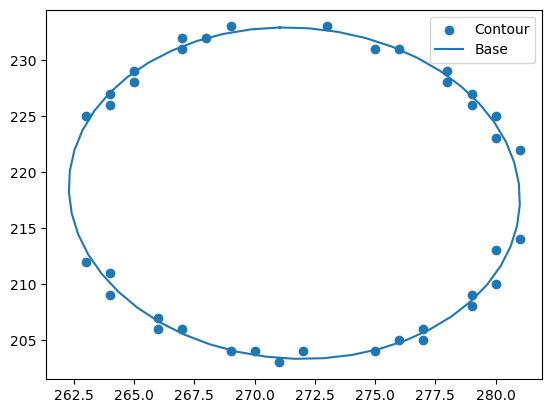

In [7]:
# Ellipse fitting example
iii = images[0][5]
pb, b1 = find_pupil_basic(iii)
plot_features(b1, pb)

(test:improve)=
## <i class="fas fa-exclamation-circle mandatory"></i> Test and evaluation
Below we provide code for detecting the pupil in each image in every dataset and for constructing training and testing datasets. You have to re-add the evaluation code from last weeks exercise. 

**A): <i class="fas fa-code"></i>** **Copy evaluation code:** Copy your evaluation code for calculating the *root mean squared error* from part 1. We recommend you set up a function that returns the *rmse* for a specific dataset. This will make the general evaluation easier.

**B): <i class="fas fa-code"></i>** **Create barplot of rmse:** Visualise the *rmse* for each dataset by using a barplot.

**C): <i class="fas fa-code"></i>** **Write code for showing samples of detected pupil ellipses:** Implement a function for showing samples of detected pupils shown in the source images. The result should be similar to the visualisation from part 1 of the exercise (although it doesn't need to print every image).

**D): <i class="fas fa-code"></i>** **Evaluate:** Answer the following questions:
- How well does the pupil detector work? Does it work equally well for all datasets and images?
- Identify situations where the detector is less precise and describe their characteristics. 
- Make at least one improvement to the detector (or an attempt) and discuss the difference.
- How do the gaze results compare to the pupil results? Describe the reason for any discrepancies.

In [9]:
# Base data
positions_train = [df.iloc[:9] for df in positions]
positions_test = [df.iloc[9:] for df in positions]
images_train = [li[:9] for li in images]
images_test = [li[9:] for li in images]

# Uncomment the following lines when your find_pupil_basic function is working

# Find pupils and construct dataframes
pupils_basic = [[find_pupil_basic(ii)[0].params for ii in images_row] for images_row in images]
pupils_basic = [pd.DataFrame(p, columns=['cx', 'cy', 'ax', 'ay', 'angle']) for p in pupils_basic]
# Create train and test splits
pupils_basic_train = [df.iloc[:9] for df in pupils_basic]
pupils_basic_test = [df.iloc[9:] for df in pupils_basic]

C:\Users\mikke\AppData\Local\Temp\ipykernel_14188\2418057002.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


Set: 0


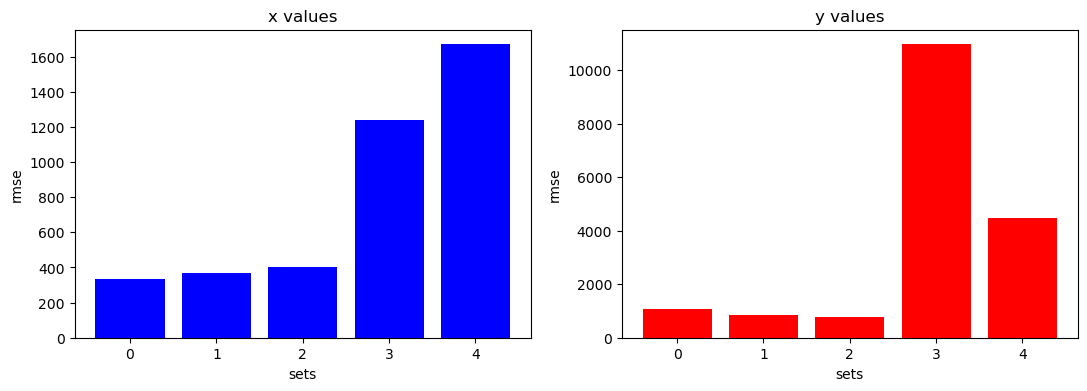

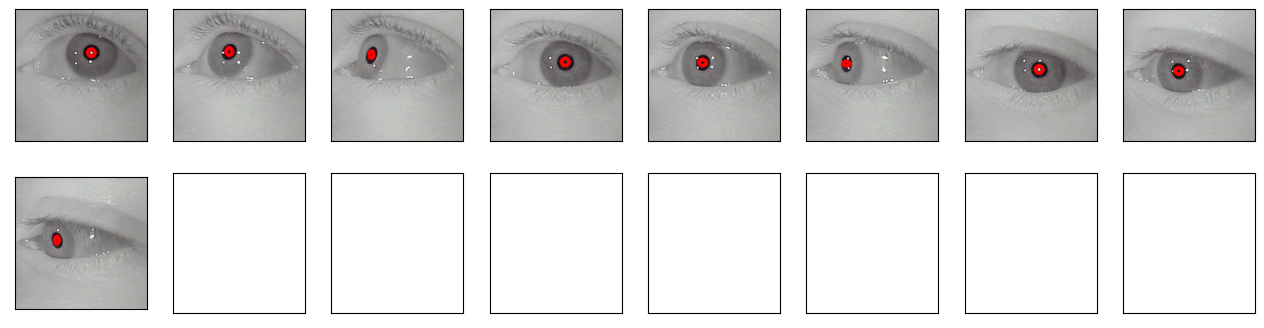

In [86]:
# Write your solution here.

# A) ---------------------------------
# Calculate RMSE
def rmse(X, y):
    sum = 0
    for i in range(0, len(X)):
        sum += np.power(X[i] - y[i], 2)
    mse = (1/len(X)) * sum

    return np.sqrt(mse)

# B) ---------------------------------
# Calculating RMSE for x and y coordinates for every test data set
rmseXs = np.array([])
rmseYs = np.array([])
sets = np.array([])
for case in range(0, len(pupils_basic_test)):
    xs, ys = calculatePredictions(case, pupils_basic_test, pupils_basic_train, positions_train, usedOrder)
    trueValues = trueValuesToArray(case, pupils_basic_test)
    rmseX = rmse(xs, trueValues[0])
    rmseY = rmse(ys, trueValues[1])
    rmseXs = np.append(rmseXs, rmseX)
    rmseYs = np.append(rmseYs, rmseY)
    sets = np.append(sets, case)


# Bar plot of rmses:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.bar(sets, rmseXs, color = 'blue')
plt.title("x values")
plt.xlabel("sets")
plt.ylabel("rmse")
plt.subplot(132)
plt.bar(sets, rmseYs, color = 'red')
plt.title("y values")
plt.xlabel("sets")
plt.ylabel("rmse")


# C) ---------------------------------
# Function show_example_features() to show elipses drawn onto the pupil picture taken from assignment 1 Gaze Prediction:
def show_example_features(images, pupils):
    """Draw a grid of images with the predicted pupils drawn on top."""
    n = len(images)
    cols = 8
    rows = n//8+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, d in enumerate(images):
        img = d.copy()
        row = pupils.iloc[i]
        img = cv.ellipse(img, (int(row['cx']), int(row['cy'])), (int(row['ax']/2), int(row['ay']/2)), row['angle'], 0, 360, (255, 0, 0), 5)
        ax[i//cols, i%cols].imshow(center_crop(img, (250, 250)))
    for row in ax:
        for a in row:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
    plt.show()

# Function to show every pupil
def showDetectedPupils(set):
    print("Set:", set)
    show_example_features(images_train[set], pupils_basic_train[set])

showDetectedPupils(0)


# D) ---------------------------------
# Evaluation:

# First of all, the pupil detector seems to be working somewhat fine in most cases.
# In some sets there are a couple outliers, where the elipse drawn is horizontal, where it really should be vertical (how it stretches)
# For example, in set 0 image 6 (as shown in the output of this cell):
# It can be seen that the elipse does not actually follow the outline of the pupil, but somehow goes vertically across instead.

# Also, there seem to be a common trend in all cases that the elipses drawn are smaller than the actual pupil.
# I would guess this is because of the thresholding and morphology done to the image, maybe altering the size of the "BLOBS" detected.
# Either way, overall the correct pupil candidates seems to be chosen as the correct pupil position in the images.

# 



(ransac)=
## <i class="fas fa-exclamation-circle mandatory"></i> RANSAC
You now have a base implementation for detecting pupils. However, like with regular regression, the approximation method is sensitive to outliers. In this case, outliers may be spurious points caused by noise in the thresholding phase. Using RANSAC might improve the detection accuracy slightly by ignorring these outliers.

You have to implement the function `ransac`. The function `find_pupil_ransac` should use the same method as the `find_pupil_basic` function with the exceptation that ellipse approximation is delegated to the `ransac` function. You are welcome to combine the pupil detection functions if you think that approach is easier.

**A): <i class="fas fa-code"></i>** **Implement RANSAC:** Use information from the course to implement the RANSAC algorithm. We provide a few hints:
- You need to select a subset of `points`. The existing parameters suggest that each subset should consist of `len(points)*frac` points. You can use the following Numpy code to select a subset:
    ```
    subset_idx = np.random.choice(len(points), int(len(points)*frac), replace=False)
    subset = points[subset_idx]
    ```
- Create a new `EllipseModel` for each iteration and estimate parameters like you did previously.
- Use the `.residuals` method of the ellipse model to calculate the error of each contour point in `points`.
- Count the number of points with an error less than `distance`.
- Keep track of the best model, i.e. the one with most *inliers* (points below the error distance threshold).
**B): <i class="fas fa-code"></i>** **Finish `find_pupil_ransac`:** Complete the function and return the model parameters (a list of five values).

**C): <i class="fas fa-code"></i>** **Questions:** Answer the following:
- Make a qualitative assessment of how the RANSAC approach compares to the simple approach. If you find a striking example, please discuss it.

In [ ]:
def ransac(points, frac=0.6, distance=0.5, iters=50):
    # Write your implementation here.
    return None, 0

def find_pupil_ransac(img, threshold=50):
    """Detects and returns a single pupil candidate for a given image.

    Returns: A pupil candidate in OpenCV ellipse format.
    """
    # Write your implementation here.
    model = EllipseModel()
    contour = []
    return model, contour

In [ ]:
iii = images[0][5]
pb, b1 = find_pupil_basic(iii)
pr, b2 = find_pupil_ransac(iii)
# Uncomment when find_pupil_ransac is working.
# plot_features(b2, pb, pr)

(evaluation:two)=
## <i class="fas fa-exclamation-circle mandatory"></i> Evaluation

You now have to evaluate and compare the RANSAC and basic approach to pupil detection. We have included some code to generate pupil features using the RANSAC method for all datasets. The code is in the cell below this one. Just like for the basic version, we have created a training and test dataset for you to use in the gaze model.

**A): <i class="fas fa-code"></i>** **Calculate errors for RANSAC:** Calculate the *rmse* for each individual dataset when using the RANSAC ellipse approximation method. Calculate the errors for at least two different sets of parameters for the `ransac` function.

**B): <i class="fas fa-code"></i>** **Compare performance:** Visualise the errors of all approaches in the same plot and answer the following:
- Does the RANSAC model improve performance and if yes, how significantly?
- Explain any difference between the two RANSAC models. You should be able to explain how the parameters have impacted the outcome.

**C): <i class="fas fa-code"></i>** **Reflecting on the gaze error:** You will likely find that, even with RANSAC, the gaze error is still relatively high for the first three datasets and extremely high for the last two datasets. Answer the following:
- What is the reason for this? You should be able to relate this to the concept of bias from the course. Consider the following thought experiment: What if the pupil detection method was perfect - what would the gaze error be? *Hint: The two datasets where the head is freely moving should reveal what our current model does not account for*.

In [ ]:
# Uncomment the following lines when your find_pupil_basic function is working

# pupils_ransac = [[find_pupil_ransac(ii)[0].params for ii in images_row] for images_row in tqdm(images)]
# pupils_ransac = [pd.DataFrame(p, columns=['cx', 'cy', 'ax', 'ay', 'angle']) for p in pupils_ransac]
# pupils_ransac_train = [df.iloc[:9] for df in pupils_ransac]
# pupils_ransac_test = [df.iloc[9:] for df in pupils_ransac]

In [ ]:
def gaze_error_ransac(idx):
    # Your solution
    return 0

gaze_error_ransac(0)